In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Caminho para o seu arquivo CSV
# Por favor, ajuste se o notebook não estiver na mesma pasta raiz do projeto
file_path = 'dataset/Aventa_AV7_IET_OST_SCADA.csv'

try:
    # Carregar o arquivo em um DataFrame do pandas
    df = pd.read_csv(file_path)

    print("Arquivo carregado com sucesso!")

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho '{file_path}'")
    print("Verifique se o caminho está correto e se o arquivo CSV está na pasta indicada.")

Arquivo carregado com sucesso!


In [2]:
# Verificando se o DataFrame foi carregado antes de prosseguir
if 'df' in locals():
    # 1. Listar todas as colunas do dataset
    print("--- COLUNAS DO DATASET ---")
    lista_de_colunas = df.columns.tolist()
    print(lista_de_colunas)
    print(f"\nTotal de colunas: {len(lista_de_colunas)}")

    # 2. Exibir a primeira linha de dados
    print("\n\n--- PRIMEIRA LINHA DE DADOS (df.head(1)) ---")
    # Usamos .T (transpor) para facilitar a visualização quando há muitas colunas
    print(df.head(10).T)

--- COLUNAS DO DATASET ---
['Datetime', 'RotorSpeed', 'GeneratorSpeed', 'GeneratorTemperature', 'WindSpeed', 'PowerOutput', 'SpeiseSpannung', 'StatusAnlage', 'MaxWindHeute', 'offsetWindDirection', 'PitchDeg']

Total de colunas: 11


--- PRIMEIRA LINHA DE DADOS (df.head(1)) ---
                                            0                        1  \
Datetime              2021-12-31 23:00:00.647  2021-12-31 23:00:01.647   
RotorSpeed                                0.0                      0.0   
GeneratorSpeed                            0.0                      0.0   
GeneratorTemperature                     11.6                     11.6   
WindSpeed                                 0.0                      0.0   
PowerOutput                               0.0                      0.0   
SpeiseSpannung                           27.8                     27.8   
StatusAnlage                             13.0                     13.0   
MaxWindHeute                              0.0           

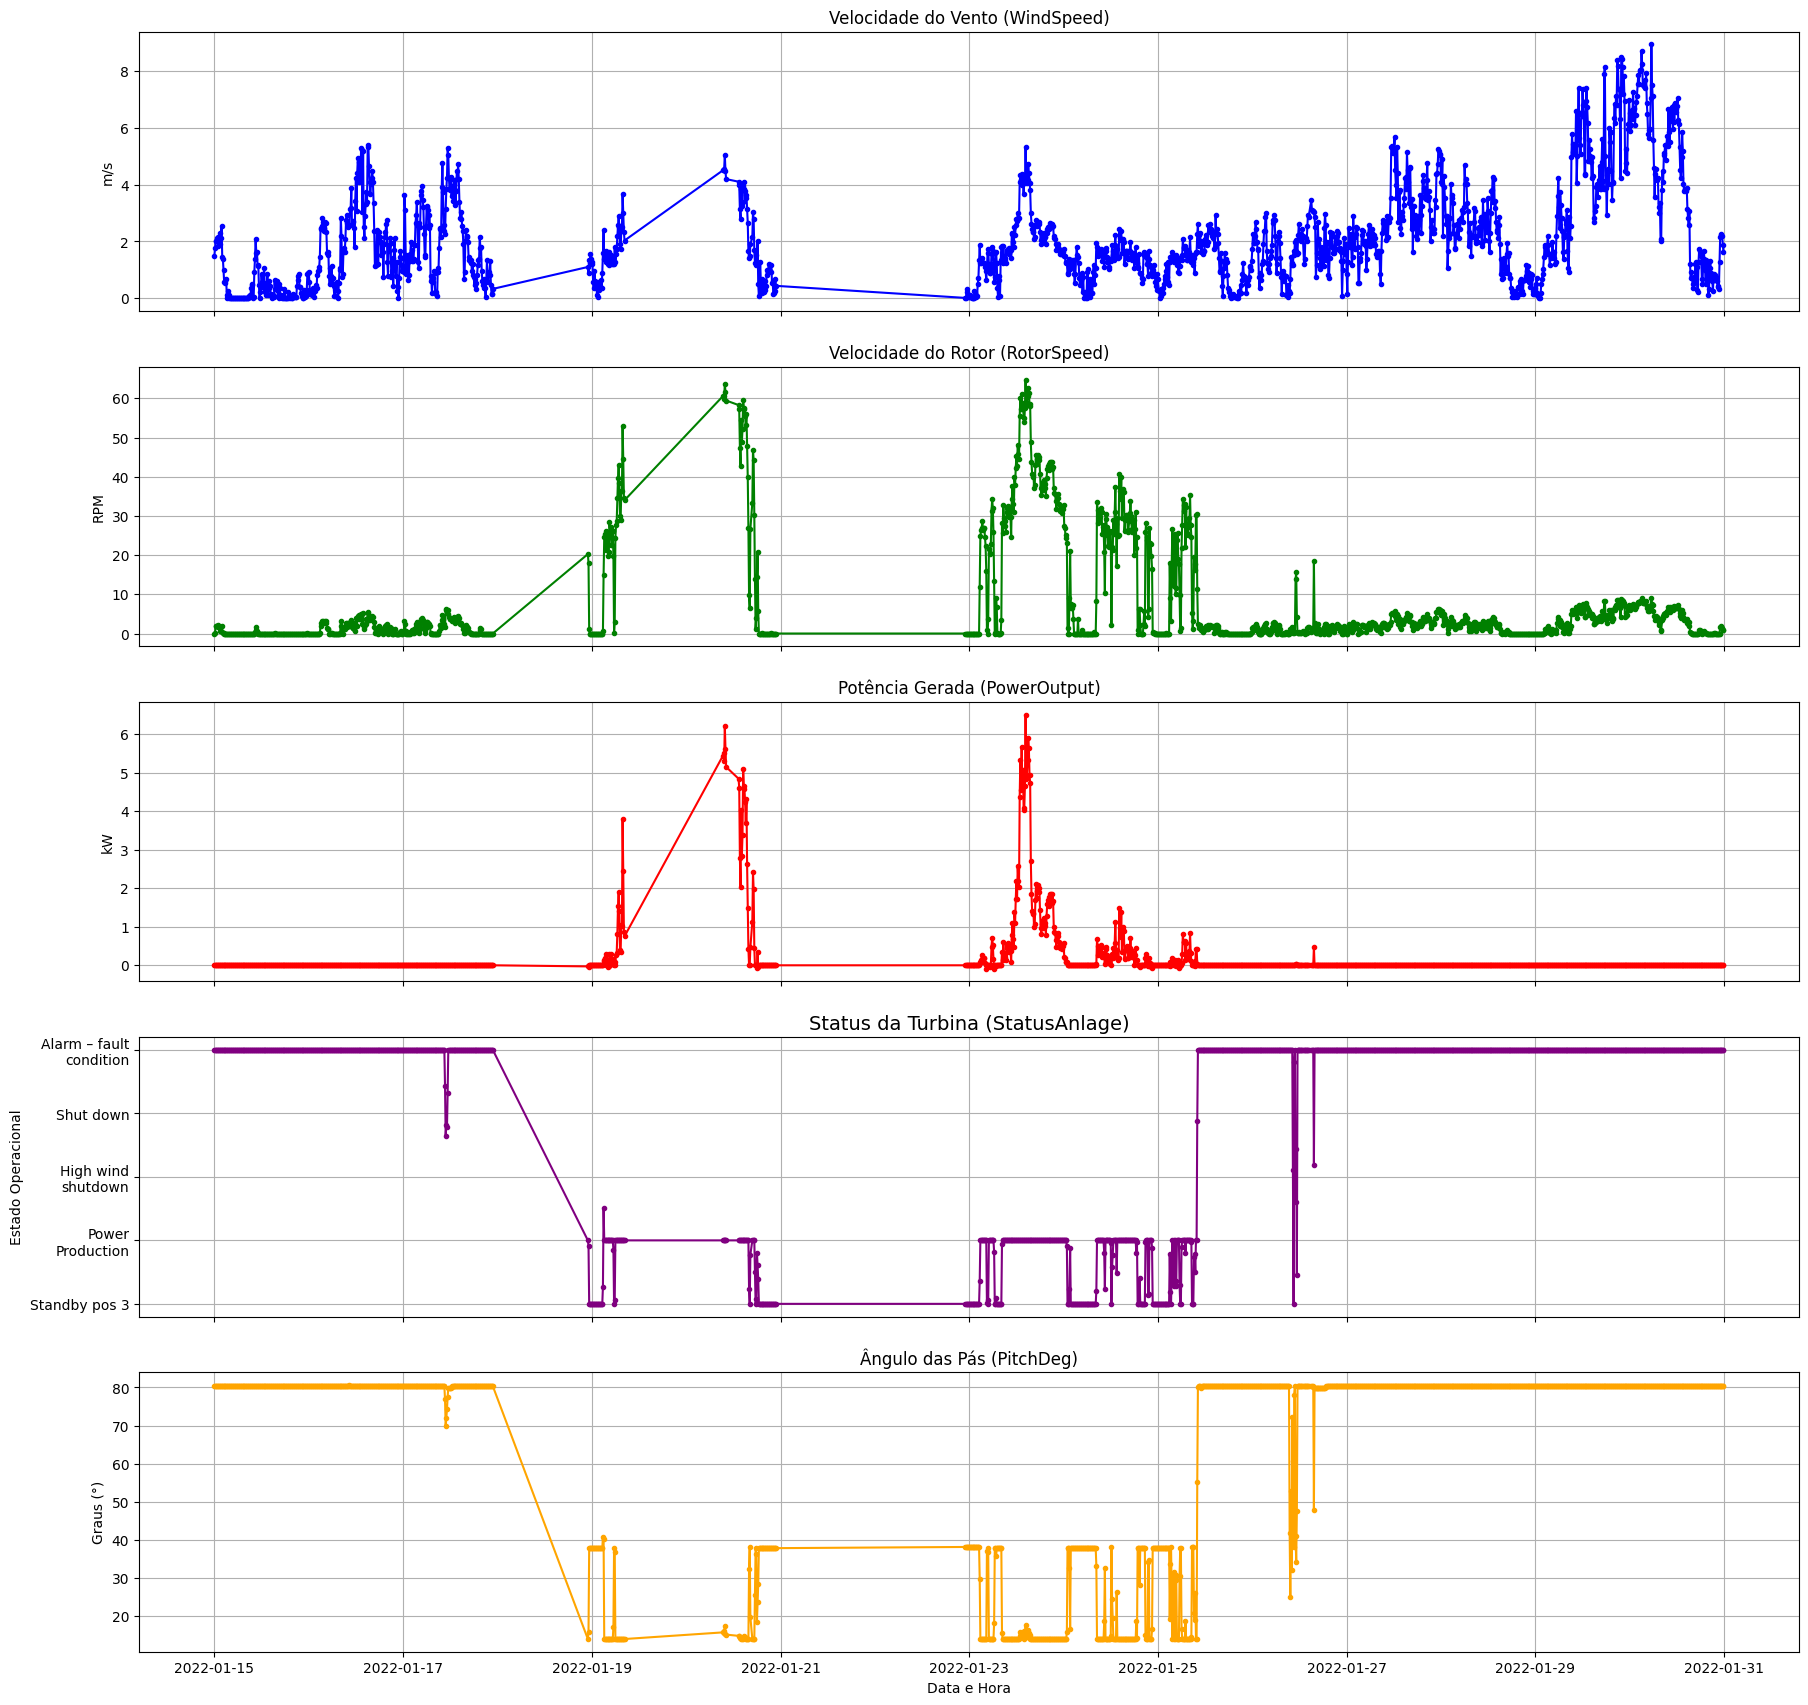

In [3]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# --- O MAPA DE STATUS ---
status_map = {
    0: "Initialize system", 1: "Feathered search 1", 2: "Feathered search 2",
    3: "Feathered pos 1", 4: "Function test 1", 5: "Function test 2",
    6: "Feathered pos 2", 7: "Standby pos 1", 8: "Standby pos 2",
    9: "Standby pos 3", 10: "Power Production", 11: "High wind shutdown",
    12: "Shut down", 13: "Alarm – fault condition"
}

# --- PREPARAÇÃO E REAMOSTRAGEM ---
# O código assume que a variável 'df' já foi carregada em uma célula anterior
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

agregacoes = {
    'WindSpeed': ['mean', 'count'], 'RotorSpeed': ['mean', 'count'],
    'PowerOutput': ['mean', 'count'], 'StatusAnlage': ['mean'], 'PitchDeg': ['mean']
}
df_agg = df.resample('10T').agg(agregacoes)
df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]

pontos_esperados = 600
limiar_disponibilidade = 0.9
df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

# --- LIMPEZA DE DADOS (REMOVENDO OUTLIERS DE STATUS) ---
df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(range(14))].copy()

# --- PARÂMETROS DE FILTRAGEM ---
data_inicio = '2022-01-15'
data_fim = '2022-01-30'
df_periodo = df_limpo.loc[data_inicio:data_fim]

# --- CRIANDO GRÁFICOS FINAIS ---
fig, axs = plt.subplots(5, 1, figsize=(20, 18), sharex=True)

axs[0].plot(df_periodo.index, df_periodo['WindSpeed_mean'], 'b.-'); axs[0].set_title('Velocidade do Vento (WindSpeed)'); axs[0].set_ylabel('m/s'); axs[0].grid(True)
axs[1].plot(df_periodo.index, df_periodo['RotorSpeed_mean'], 'g.-'); axs[1].set_title('Velocidade do Rotor (RotorSpeed)'); axs[1].set_ylabel('RPM'); axs[1].grid(True)
axs[2].plot(df_periodo.index, df_periodo['PowerOutput_mean'], 'r.-'); axs[2].set_title('Potência Gerada (PowerOutput)'); axs[2].set_ylabel('kW'); axs[2].grid(True)

axs[3].plot(df_periodo.index, df_periodo['StatusAnlage_mean'], '.-', color='purple')
axs[3].set_title('Status da Turbina (StatusAnlage)', fontsize=14)
axs[3].set_ylabel('Estado Operacional')
axs[3].grid(True)
codigos_no_periodo = sorted(df_periodo['StatusAnlage_mean'].round().unique())
base_labels = [status_map.get(int(c), f"Código {c}") for c in codigos_no_periodo]
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=15, break_long_words=False)) for label in base_labels]
axs[3].set_yticks(codigos_no_periodo)
axs[3].set_yticklabels(wrapped_labels, ha='right', fontsize=10)

axs[4].plot(df_periodo.index, df_periodo['PitchDeg_mean'], '.-', color='orange')
axs[4].set_title('Ângulo das Pás (PitchDeg)'); axs[4].set_ylabel('Graus (°)')
axs[4].set_xlabel('Data e Hora'); axs[4].grid(True)


plt.subplots_adjust(left=0.15, right=0.98, top=0.95, bottom=0.05)
plt.show()

--- Gerando Painel 1: Séries Temporais de Performance ---


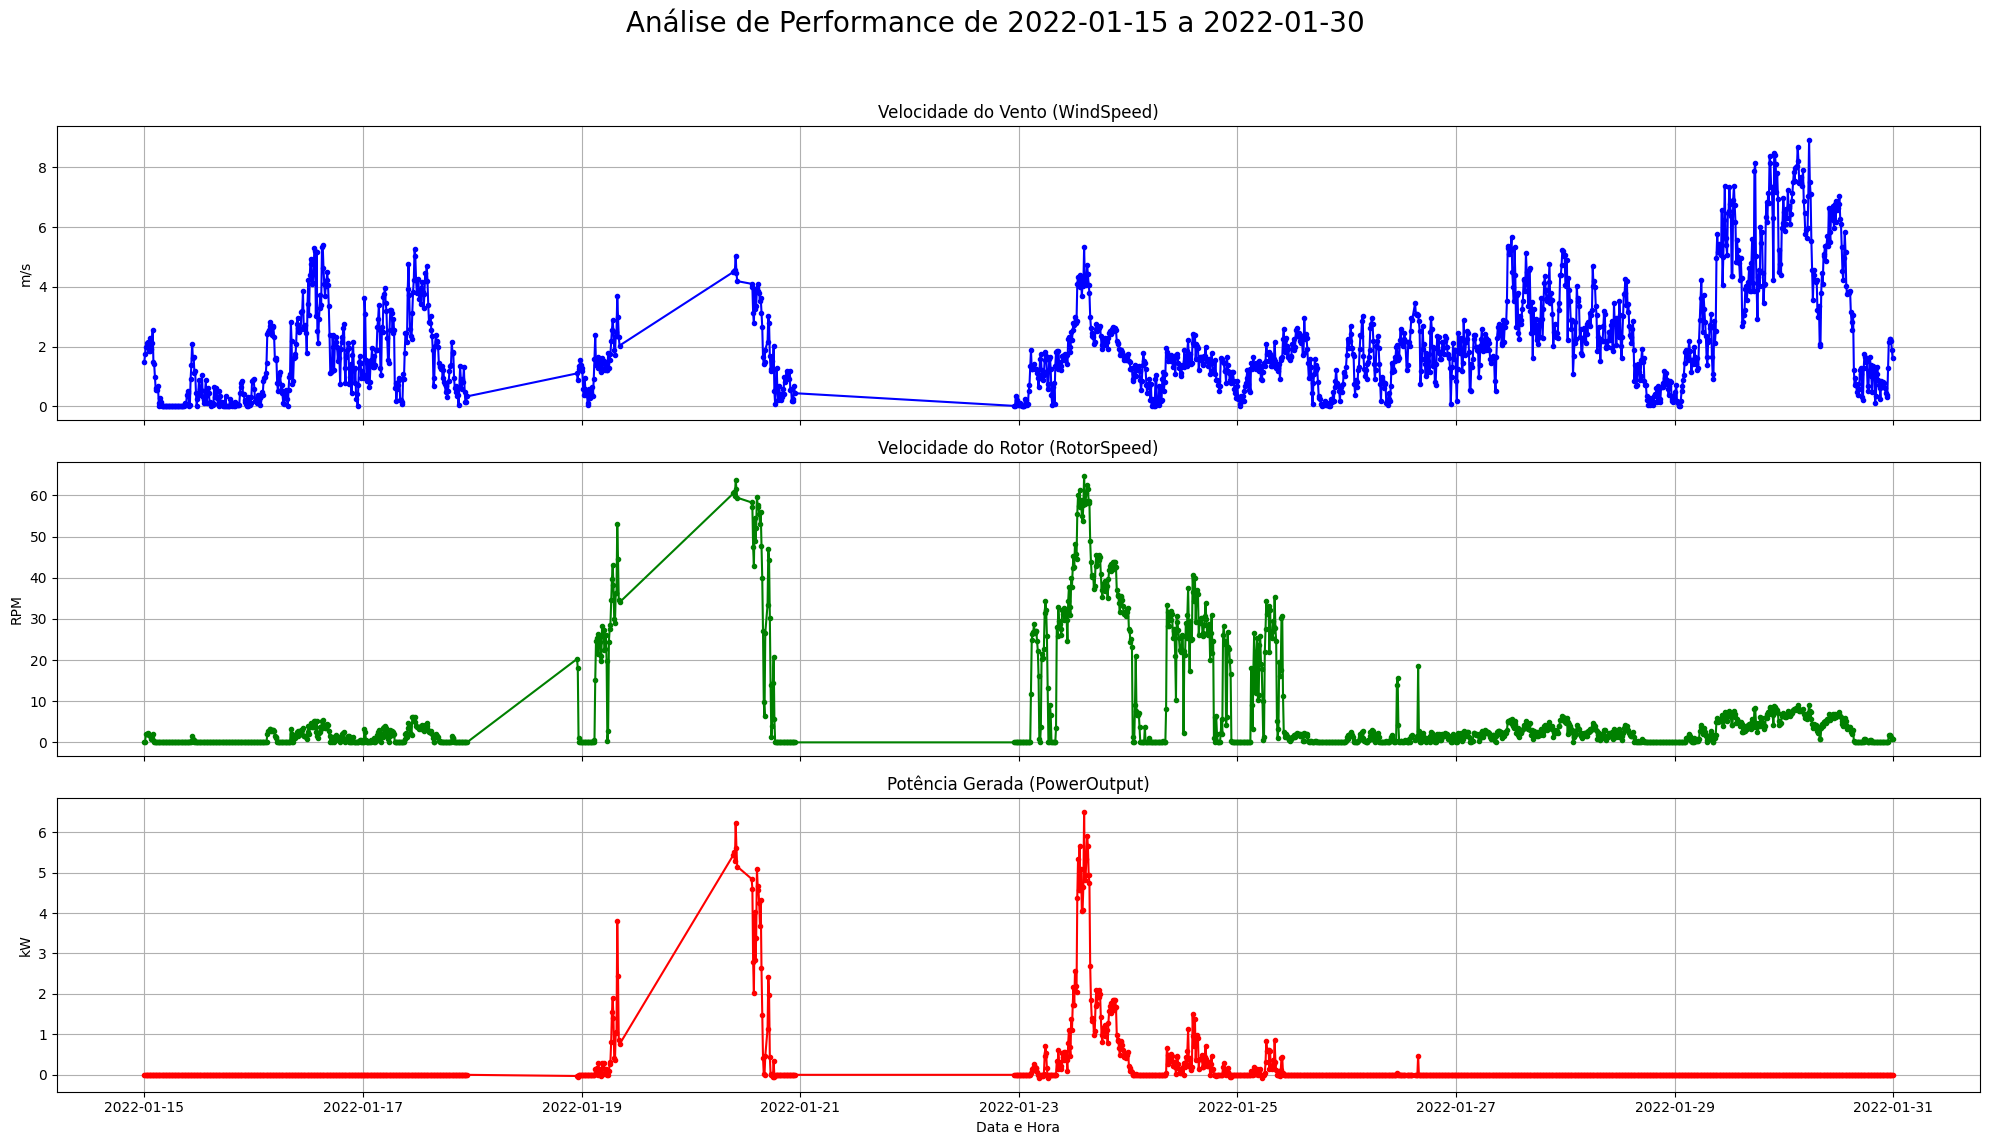

In [4]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt

# --- O MAPA DE STATUS ---
# (Precisamos dele aqui para a etapa de limpeza de dados)
status_map = {
    0: "Initialize system", 1: "Feathered search 1", 2: "Feathered search 2",
    3: "Feathered pos 1", 4: "Function test 1", 5: "Function test 2",
    6: "Feathered pos 2", 7: "Standby pos 1", 8: "Standby pos 2",
    9: "Standby pos 3", 10: "Power Production", 11: "High wind shutdown",
    12: "Shut down", 13: "Alarm – fault condition"
}

# --- PREPARAÇÃO, REAMOSTRAGEM E LIMPEZA ---
# (Assumindo que 'df' foi carregado em uma célula anterior)
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

# Note que removemos 'PitchDeg' da agregação
agregacoes = {
    'WindSpeed': ['mean', 'count'], 'RotorSpeed': ['mean', 'count'],
    'PowerOutput': ['mean', 'count'], 'StatusAnlage': ['mean']
}
df_agg = df.resample('10T').agg(agregacoes)
df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]

pontos_esperados = 600
limiar_disponibilidade = 0.9
df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

# Limpamos os dados usando as chaves válidas do nosso status_map
codigos_validos = status_map.keys()
df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(codigos_validos)].copy()

# --- PARÂMETROS DE FILTRAGEM ---
data_inicio = '2022-01-15'
data_fim = '2022-01-30'
df_periodo = df_limpo.loc[data_inicio:data_fim]

# --- CRIANDO O PAINEL 1 (Séries Contínuas) ---
print("--- Gerando Painel 1: Séries Temporais de Performance ---")
fig_linhas, axs_linhas = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
fig_linhas.suptitle(f'Análise de Performance de {data_inicio} a {data_fim}', fontsize=20)

axs_linhas[0].plot(df_periodo.index, df_periodo['WindSpeed_mean'], 'b.-')
axs_linhas[0].set_title('Velocidade do Vento (WindSpeed)'); axs_linhas[0].set_ylabel('m/s'); axs_linhas[0].grid(True)

axs_linhas[1].plot(df_periodo.index, df_periodo['RotorSpeed_mean'], 'g.-')
axs_linhas[1].set_title('Velocidade do Rotor (RotorSpeed)'); axs_linhas[1].set_ylabel('RPM'); axs_linhas[1].grid(True)

axs_linhas[2].plot(df_periodo.index, df_periodo['PowerOutput_mean'], 'r.-')
axs_linhas[2].set_title('Potência Gerada (PowerOutput)'); axs_linhas[2].set_ylabel('kW'); axs_linhas[2].grid(True)
axs_linhas[2].set_xlabel('Data e Hora')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Gerando Painel 2: Diagnóstico de Estado Operacional ---


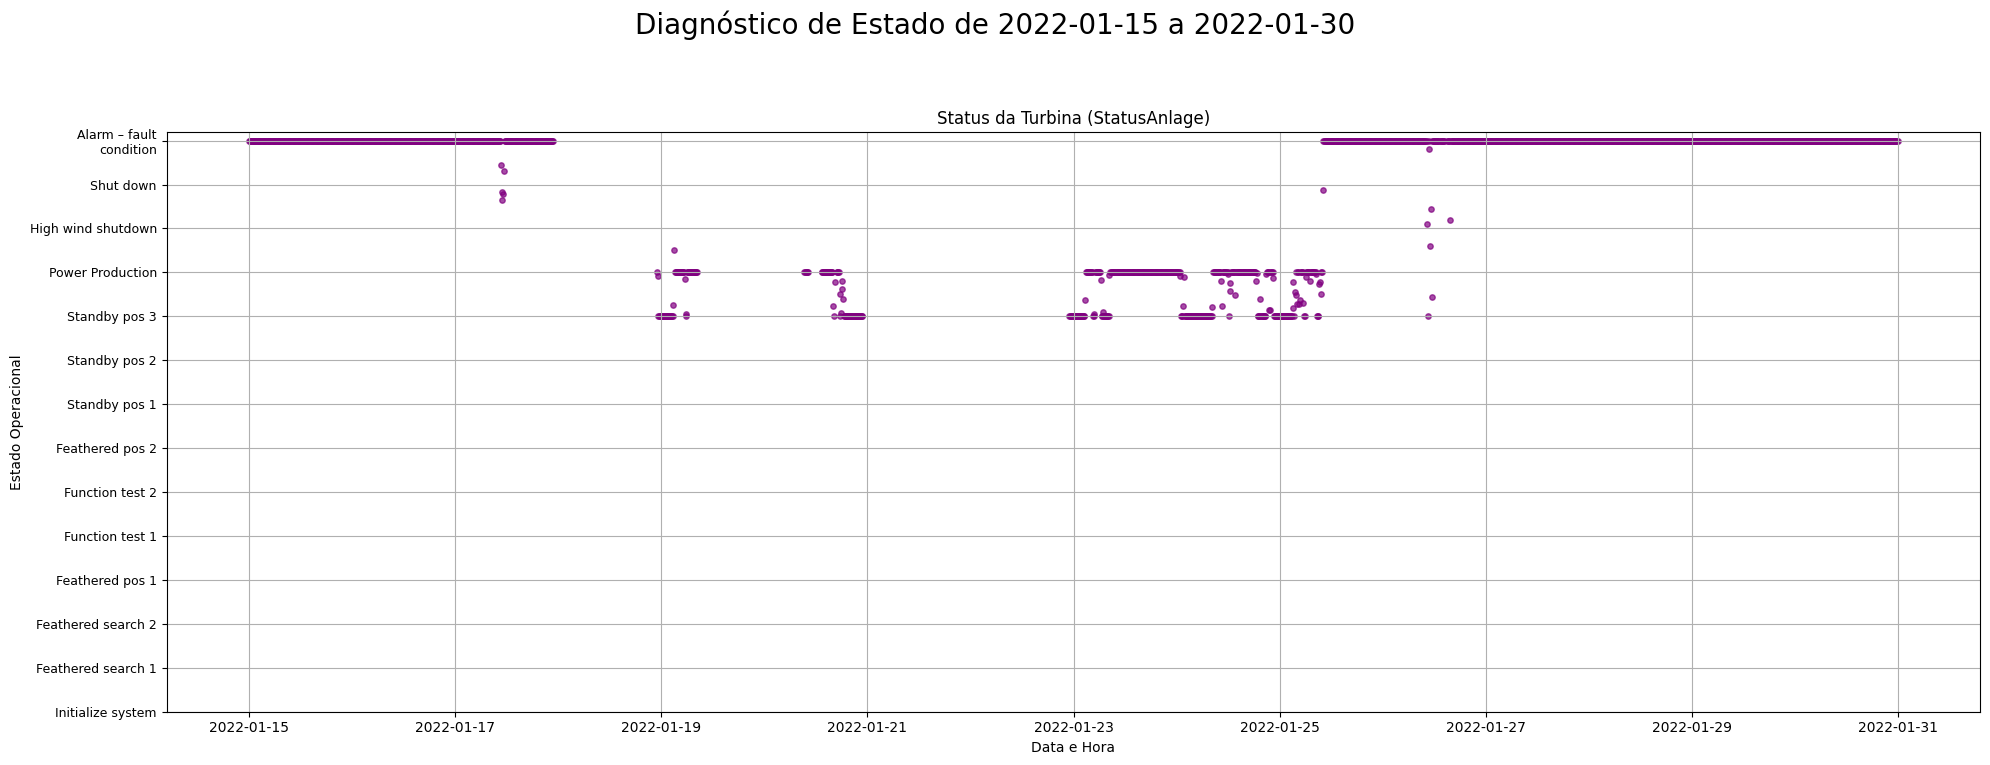

In [5]:
# Importando bibliotecas (por segurança, caso a célula seja executada de forma isolada)
import matplotlib.pyplot as plt
import textwrap

# Este código deve ser executado na célula seguinte ao Painel 1, pois ele usa o 'df_periodo'
if 'df_periodo' in locals():
    print("\n--- Gerando Painel 2: Diagnóstico de Estado Operacional ---")

    # --- CRIANDO O PAINEL 2 (Estados Discretos) ---
    fig_pontos, ax_pontos = plt.subplots(1, 1, figsize=(20, 8))
    fig_pontos.suptitle(f'Diagnóstico de Estado de {data_inicio} a {data_fim}', fontsize=20)

    # Gráfico de dispersão para os estados
    ax_pontos.scatter(df_periodo.index, df_periodo['StatusAnlage_mean'], color='purple', s=15, alpha=0.7)
    ax_pontos.set_title('Status da Turbina (StatusAnlage)')
    ax_pontos.set_ylabel('Estado Operacional')
    ax_pontos.set_xlabel('Data e Hora')
    ax_pontos.grid(True)

    # --- MUDANÇA PRINCIPAL: Forçar TODOS os labels de status no eixo Y ---
    # Pegamos todas as chaves (0-13) do nosso dicionário
    codigos_completos = list(status_map.keys())
    # Pegamos todas as descrições correspondentes
    base_labels = list(status_map.values())
    # Quebramos as linhas das descrições longas
    wrapped_labels = ['\n'.join(textwrap.wrap(label, width=20, break_long_words=False)) for label in base_labels]
    
    # Definimos os ticks e os labels do eixo Y para SEMPRE mostrar todas as 14 possibilidades
    ax_pontos.set_yticks(codigos_completos)
    ax_pontos.set_yticklabels(wrapped_labels, ha='right', fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()
else:
    print("Por favor, execute a célula do Painel 1 primeiro para preparar os dados.")

Arquivo 'dataset/Aventa_AV7_IET_OST_SCADA.csv' carregado com sucesso!

--- Reamostrando dados para médias de 10 minutos e aplicando filtro de qualidade ---
--- Removendo códigos de status inválidos ---
--- Isolando dados de 'Power Production' (Status 10) ---
Dados de operação normal prontos: 32252 registros encontrados.

--- Iniciando a Modelagem da Curva de Potência ---
Treinando o modelo Random Forest...
Modelo treinado!

--- Performance do Modelo ---
Erro Médio Absoluto (MAE): 0.286 kW
Coeficiente de Determinação (R²): 0.962 (modelo explica 96.2% da variação)

--- Gerando Gráfico da Curva de Potência Aprendida ---


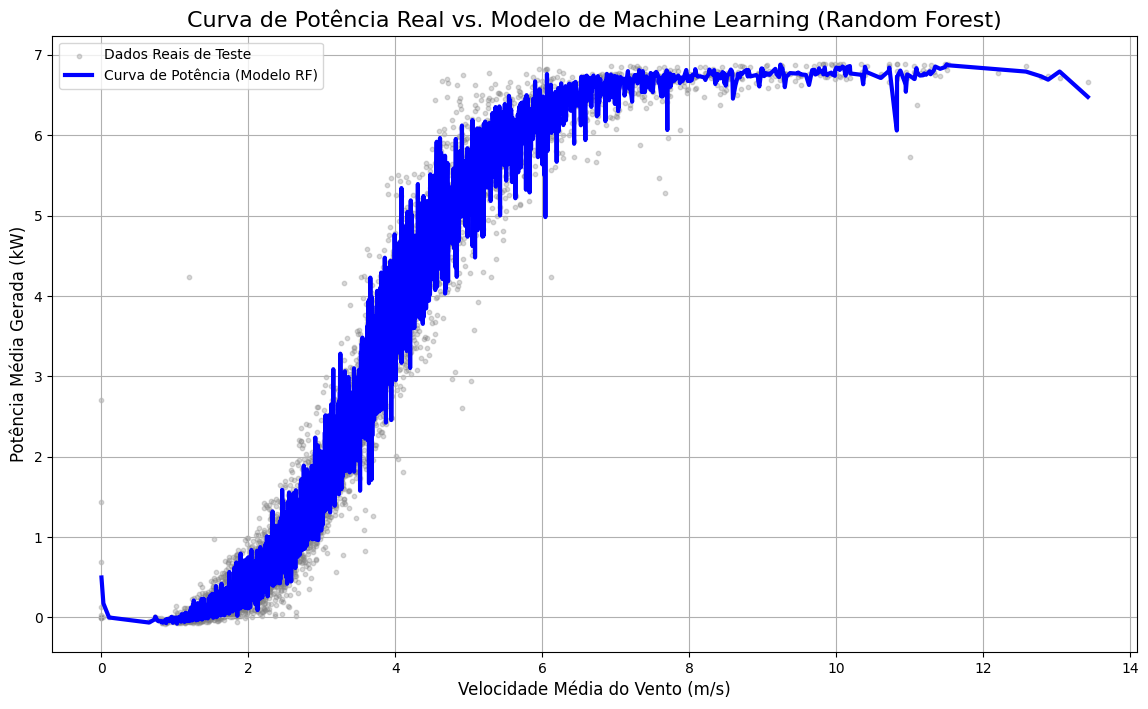

In [6]:
# --- PASSO 0: IMPORTAÇÃO DAS BIBLIOTECAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- O MAPA DE STATUS ---
status_map = {
    0: "Initialize system", 1: "Feathered search 1", 2: "Feathered search 2",
    3: "Feathered pos 1", 4: "Function test 1", 5: "Function test 2",
    6: "Feathered pos 2", 7: "Standby pos 1", 8: "Standby pos 2",
    9: "Standby pos 3", 10: "Power Production", 11: "High wind shutdown",
    12: "Shut down", 13: "Alarm – fault condition"
}

# --- PASSO 1: CARGA E PREPARAÇÃO INICIAL ---
try:
    file_path = 'dataset/Aventa_AV7_IET_OST_SCADA.csv'
    df = pd.read_csv(file_path)
    print(f"Arquivo '{file_path}' carregado com sucesso!")
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # --- PASSO 2: REAMOSTRAGEM (DOWNSAMPLING) E FILTRO DE QUALIDADE ---
    print("\n--- Reamostrando dados para médias de 10 minutos e aplicando filtro de qualidade ---")
    agregacoes = {
        'WindSpeed': ['mean', 'count'], 'RotorSpeed': ['mean'],
        'PowerOutput': ['mean'], 'StatusAnlage': ['mean']
    }
    df_agg = df.resample('10T').agg(agregacoes)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    pontos_esperados = 600  # 1Hz * 60s * 10min
    limiar_disponibilidade = 0.9
    df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

    # --- PASSO 3: LIMPEZA DE DADOS (REMOVENDO OUTLIERS) ---
    print("--- Removendo códigos de status inválidos ---")
    codigos_validos = status_map.keys()
    df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(codigos_validos)].copy()
    
    # --- PASSO 4: ISOLAR DADOS DE OPERAÇÃO NORMAL (CRIAÇÃO DO 'df_operacao') ---
    # Esta é a etapa que estava faltando no código anterior
    print("--- Isolando dados de 'Power Production' (Status 10) ---")
    STATUS_OPERACAO = 10
    df_operacao = df_limpo[df_limpo['StatusAnlage_mean'].round() == STATUS_OPERACAO].copy()
    
    if df_operacao.empty:
        print("\nAVISO: Nenhum dado de operação normal (Status 10) foi encontrado após a limpeza. A modelagem não pode continuar.")
    else:
        print(f"Dados de operação normal prontos: {len(df_operacao)} registros encontrados.")

        # --- PASSO 5: MODELAGEM DA CURVA DE POTÊNCIA COM MACHINE LEARNING ---
        print("\n--- Iniciando a Modelagem da Curva de Potência ---")

        X = df_operacao[['WindSpeed_mean']]
        y = df_operacao['PowerOutput_mean']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        
        print("Treinando o modelo Random Forest...")
        rf_model.fit(X_train, y_train)
        print("Modelo treinado!")

        y_pred = rf_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print("\n--- Performance do Modelo ---")
        print(f"Erro Médio Absoluto (MAE): {mae:.3f} kW")
        print(f"Coeficiente de Determinação (R²): {r2:.3f} (modelo explica {r2*100:.1f}% da variação)")

        print("\n--- Gerando Gráfico da Curva de Potência Aprendida ---")
        plt.figure(figsize=(14, 8))
        plt.scatter(X_test, y_test, alpha=0.3, s=10, label='Dados Reais de Teste', color='gray')
        
        sorted_zip = sorted(zip(X_test.values.ravel(), y_pred))
        X_test_sorted, y_pred_sorted = zip(*sorted_zip)
        
        plt.plot(X_test_sorted, y_pred_sorted, color='blue', linewidth=3, label='Curva de Potência (Modelo RF)')
        plt.title('Curva de Potência Real vs. Modelo de Machine Learning (Random Forest)', fontsize=16)
        plt.xlabel('Velocidade Média do Vento (m/s)', fontsize=12)
        plt.ylabel('Potência Média Gerada (kW)', fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.show()

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho '{file_path}'")


--- Gerando Série Temporal da Potência em Operação Normal (Status 10) ---


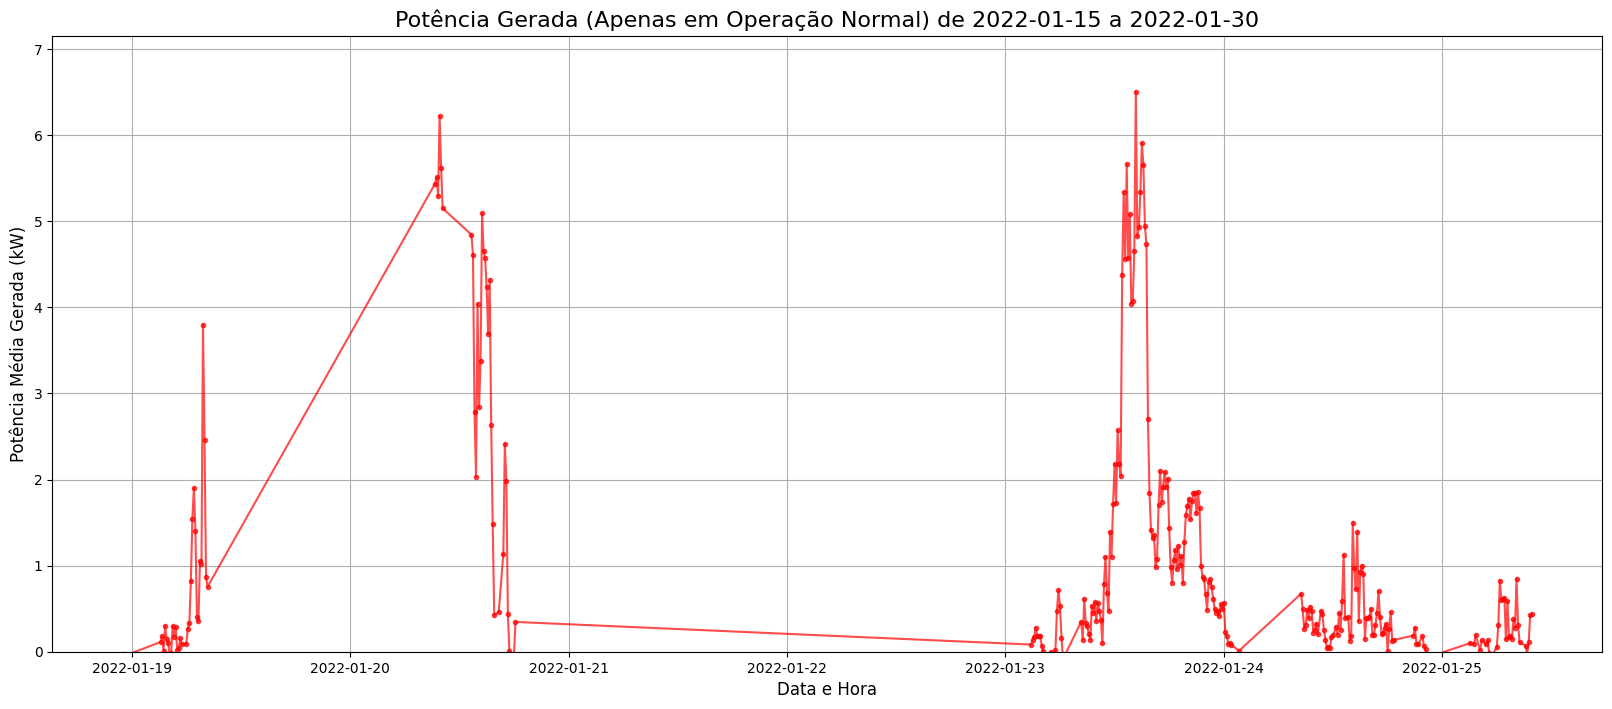

In [7]:
# Importando a biblioteca (por segurança)
import matplotlib.pyplot as plt

# O código assume que 'df_operacao' foi criado na célula anterior
if 'df_operacao' in locals() and not df_operacao.empty:

    print("\n--- Gerando Série Temporal da Potência em Operação Normal (Status 10) ---")
    
    # Filtramos para o mesmo período da nossa análise anterior para manter a consistência
    data_inicio = '2022-01-15'
    data_fim = '2022-01-30'
    df_periodo_operacao = df_operacao.loc[data_inicio:data_fim]

    plt.figure(figsize=(20, 8))
    
    plt.plot(df_periodo_operacao.index, df_periodo_operacao['PowerOutput_mean'], 'r.-', alpha=0.7)
    
    plt.title(f'Potência Gerada (Apenas em Operação Normal) de {data_inicio} a {data_fim}', fontsize=16)
    plt.xlabel('Data e Hora', fontsize=12)
    plt.ylabel('Potência Média Gerada (kW)', fontsize=12)
    plt.grid(True)
    plt.ylim(0, df_periodo_operacao['PowerOutput_mean'].max() * 1.1) # Ajusta o eixo Y para melhor visualização
    plt.show()

else:
    print("O DataFrame 'df_operacao' não foi encontrado. Por favor, execute a célula de modelagem primeiro.")

--- Treinando o modelo de referência da Curva de Potência ---
Modelo treinado com sucesso!

--- Calculando resíduos (real vs. previsto) para todos os dados de operação ---
--- Gerando gráfico de diagnóstico de performance ---


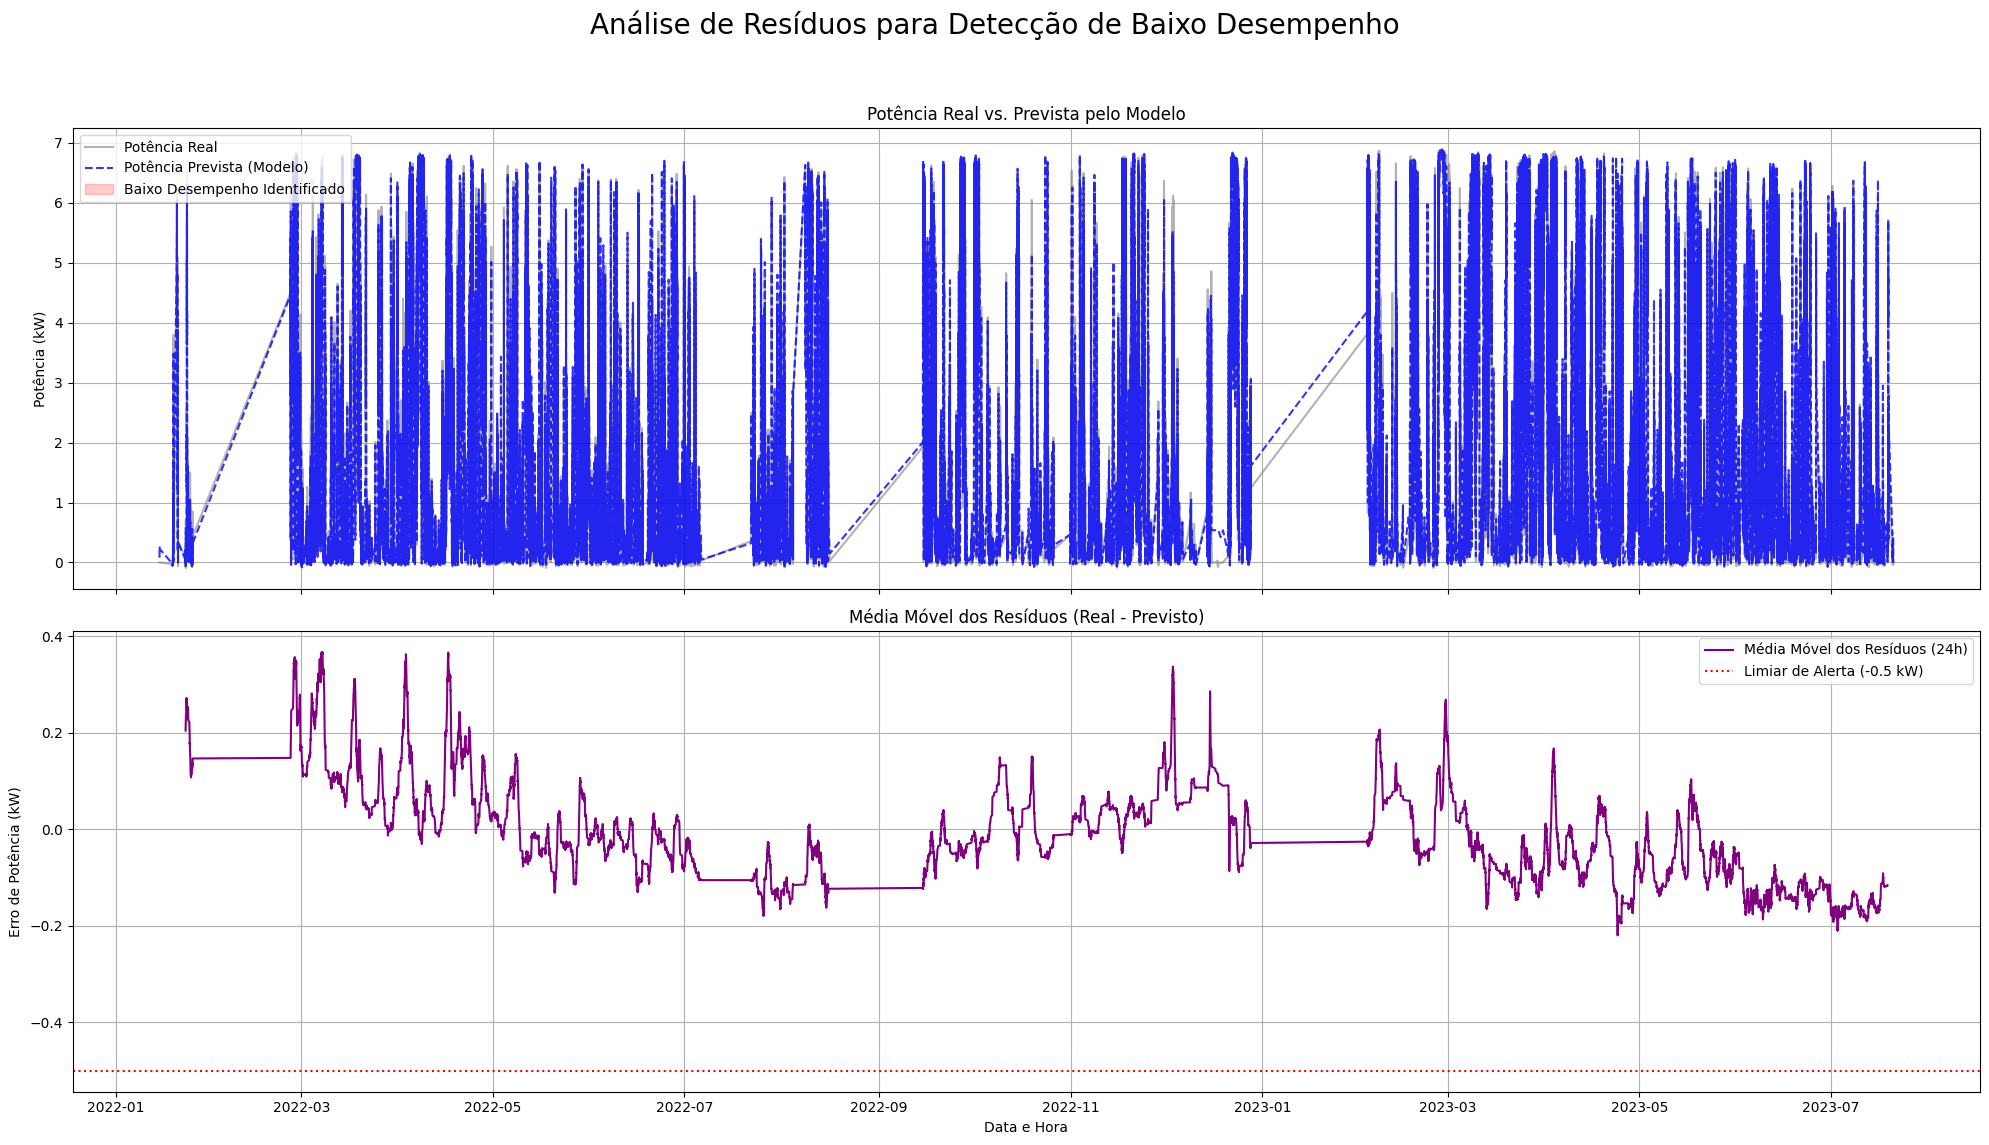

In [8]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# --- PASSO 0: PREPARAÇÃO COMPLETA DOS DADOS ---
# (Reunimos todos os passos anteriores para garantir a execução)
try:
    # O MAPA DE STATUS
    status_map = {10: "Power Production", 13: "Alarm – fault condition"}
    
    file_path = 'dataset/Aventa_AV7_IET_OST_SCADA.csv'
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    agregacoes = {
        'WindSpeed': ['mean', 'count'], 'RotorSpeed': ['mean'],
        'PowerOutput': ['mean'], 'StatusAnlage': ['mean']
    }
    df_agg = df.resample('10T').agg(agregacoes)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    pontos_esperados = 600
    limiar_disponibilidade = 0.9
    df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

    codigos_validos = [10, 13] # Focando nos principais
    df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(codigos_validos)].copy()

    STATUS_OPERACAO = 10
    df_operacao = df_limpo[df_limpo['StatusAnlage_mean'].round() == STATUS_OPERACAO].copy()

    if df_operacao.empty:
        print("AVISO: Nenhum dado de operação normal (Status 10) foi encontrado.")
    else:
        # --- PASSO 1: TREINAR O MODELO DE CURVA DE POTÊNCIA ---
        print("--- Treinando o modelo de referência da Curva de Potência ---")
        X = df_operacao[['WindSpeed_mean']]
        y = df_operacao['PowerOutput_mean']
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X, y)
        print("Modelo treinado com sucesso!")

        # --- PASSO 2: CÁLCULO DOS RESÍDUOS ---
        print("\n--- Calculando resíduos (real vs. previsto) para todos os dados de operação ---")
        # Usamos o modelo para prever a potência em todo o dataset de operação
        predicted_power = rf_model.predict(df_operacao[['WindSpeed_mean']])
        df_operacao['predicted_power'] = predicted_power
        # Calculamos o resíduo
        df_operacao['residual'] = df_operacao['PowerOutput_mean'] - df_operacao['predicted_power']

        # --- PASSO 3: ANÁLISE DE RESÍDUOS COM MÉDIA MÓVEL ---
        # A janela de 144 representa 24 horas (144 * 10 minutos = 1440 minutos)
        window_size = 144 
        df_operacao['residual_rolling_mean'] = df_operacao['residual'].rolling(window=window_size, center=True).mean()

        # Definimos um limiar para o que consideramos "baixo desempenho"
        # Por exemplo, uma perda consistente de 0.5 kW
        underperformance_threshold = -0.5 # kW

        # Identificamos os períodos de baixo desempenho
        df_operacao['underperforming'] = df_operacao['residual_rolling_mean'] < underperformance_threshold

        # --- PASSO 4: VISUALIZAÇÃO DE DIAGNÓSTICO ---
        print("--- Gerando gráfico de diagnóstico de performance ---")
        
        fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
        fig.suptitle('Análise de Resíduos para Detecção de Baixo Desempenho', fontsize=20)

        # Gráfico 1: Potência Real e Prevista
        axs[0].plot(df_operacao.index, df_operacao['PowerOutput_mean'], label='Potência Real', color='gray', alpha=0.6)
        axs[0].plot(df_operacao.index, df_operacao['predicted_power'], label='Potência Prevista (Modelo)', color='blue', linestyle='--', alpha=0.8)
        # Destaca em vermelho as áreas de baixo desempenho
        axs[0].fill_between(df_operacao.index, 0, df_operacao['PowerOutput_mean'].max(), where=df_operacao['underperforming'], 
                            color='red', alpha=0.2, label='Baixo Desempenho Identificado')
        axs[0].set_title('Potência Real vs. Prevista pelo Modelo')
        axs[0].set_ylabel('Potência (kW)')
        axs[0].legend()
        axs[0].grid(True)

        # Gráfico 2: Média Móvel dos Resíduos
        axs[1].plot(df_operacao.index, df_operacao['residual_rolling_mean'], label=f'Média Móvel dos Resíduos ({window_size*10 // 60}h)', color='purple')
        # Linha do nosso limiar de alerta
        axs[1].axhline(y=underperformance_threshold, color='red', linestyle=':', label=f'Limiar de Alerta ({underperformance_threshold} kW)')
        axs[1].fill_between(df_operacao.index, df_operacao['residual_rolling_mean'].min(), underperformance_threshold, 
                            where=df_operacao['underperforming'], color='red', alpha=0.2)
        axs[1].set_title('Média Móvel dos Resíduos (Real - Previsto)')
        axs[1].set_ylabel('Erro de Potência (kW)')
        axs[1].set_xlabel('Data e Hora')
        axs[1].legend()
        axs[1].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho '{file_path}'")


--- Adicionando consciência temporal ao modelo ---
Nova feature 'tempo_desde_ultimo_dado' criada com sucesso.

--- Iniciando a Modelagem da Curva de Potência com Consciência Temporal ---
Treinando o modelo Random Forest aprimorado...
Modelo treinado!

--- Performance do Novo Modelo ---
Erro Médio Absoluto (MAE): 0.280 kW
Coeficiente de Determinação (R²): 0.963 (modelo explica 96.3% da variação)

--- Gerando Gráfico da Curva de Potência Aprendida ---


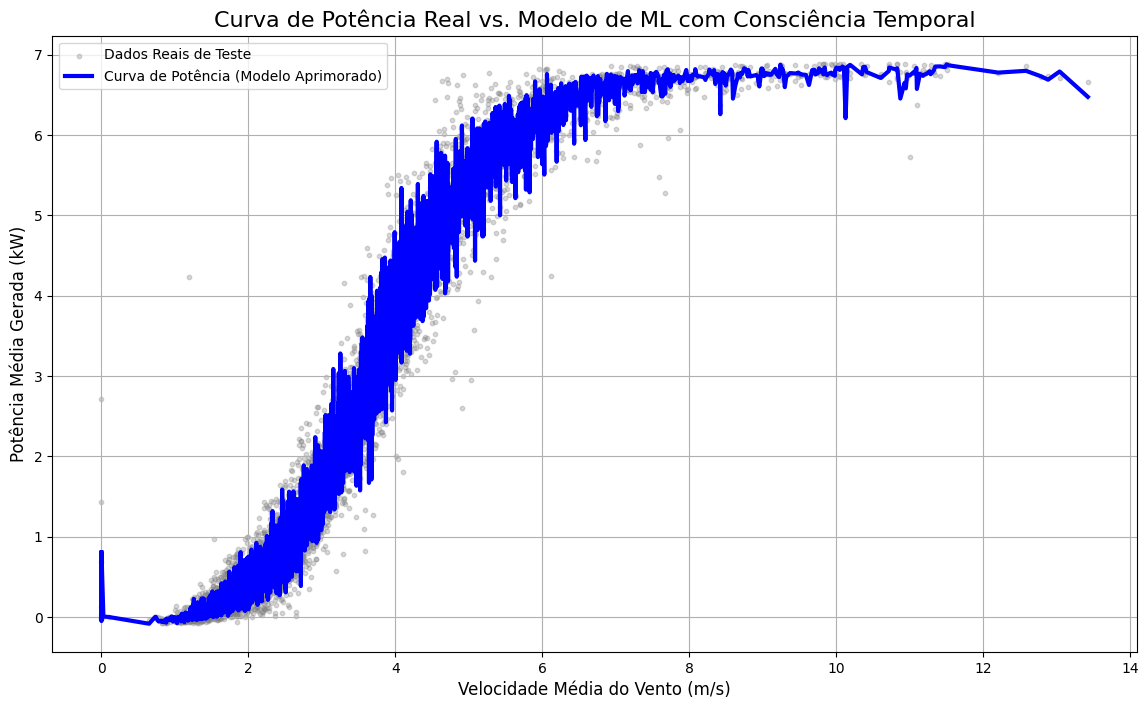

In [9]:
# --- PASSO 0: IMPORTAÇÃO DAS BIBLIOTECAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# --- O MAPA DE STATUS ---
status_map = {10: "Power Production", 13: "Alarm – fault condition"}

try:
    # --- PASSO 1, 2, 3: CARGA, PREPARAÇÃO, REAMOSTRAGEM E LIMPEZA ---
    file_path = 'dataset/Aventa_AV7_IET_OST_SCADA.csv'
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    agregacoes = {
        'WindSpeed': ['mean', 'count'], 'RotorSpeed': ['mean'],
        'PowerOutput': ['mean'], 'StatusAnlage': ['mean']
    }
    df_agg = df.resample('10T').agg(agregacoes)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    pontos_esperados = 600
    limiar_disponibilidade = 0.9
    df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

    codigos_validos = [10, 13]
    df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(codigos_validos)].copy()

    STATUS_OPERACAO = 10
    df_operacao = df_limpo[df_limpo['StatusAnlage_mean'].round() == STATUS_OPERACAO].copy()

    if df_operacao.empty:
        print("AVISO: Nenhum dado de operação normal (Status 10) foi encontrado.")
    else:
        # --- NOVO PASSO: ENGENHARIA DE FEATURES TEMPORAIS ---
        print("\n--- Adicionando consciência temporal ao modelo ---")
        # Calculamos a diferença de tempo entre cada registro
        df_operacao['time_delta'] = df_operacao.index.to_series().diff()
        # Convertemos para minutos para ser um número fácil para o modelo usar
        df_operacao['tempo_desde_ultimo_dado'] = df_operacao['time_delta'].dt.total_seconds() / 60.0
        # O primeiro valor será nulo (NaN), então preenchemos com um valor neutro (10 min)
        df_operacao['tempo_desde_ultimo_dado'].fillna(10.0, inplace=True)
        print("Nova feature 'tempo_desde_ultimo_dado' criada com sucesso.")

        # --- PASSO 4: MODELAGEM COM A NOVA FEATURE ---
        print("\n--- Iniciando a Modelagem da Curva de Potência com Consciência Temporal ---")

        # ATUALIZAÇÃO: 'X' agora inclui a nova feature temporal
        X = df_operacao[['WindSpeed_mean', 'tempo_desde_ultimo_dado']]
        y = df_operacao['PowerOutput_mean']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        rf_model_temporal = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        
        print("Treinando o modelo Random Forest aprimorado...")
        rf_model_temporal.fit(X_train, y_train)
        print("Modelo treinado!")

        y_pred = rf_model_temporal.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print("\n--- Performance do Novo Modelo ---")
        print(f"Erro Médio Absoluto (MAE): {mae:.3f} kW")
        print(f"Coeficiente de Determinação (R²): {r2:.3f} (modelo explica {r2*100:.1f}% da variação)")

        # --- PASSO 5: VISUALIZAÇÃO ---
        print("\n--- Gerando Gráfico da Curva de Potência Aprendida ---")
        plt.figure(figsize=(14, 8))
        plt.scatter(X_test['WindSpeed_mean'], y_test, alpha=0.3, s=10, label='Dados Reais de Teste', color='gray')
        
        # Para plotar a curva, precisamos de um 'X' ordenado
        X_test_sorted = X_test.sort_values(by='WindSpeed_mean')
        y_pred_sorted = rf_model_temporal.predict(X_test_sorted)
        
        plt.plot(X_test_sorted['WindSpeed_mean'], y_pred_sorted, color='blue', linewidth=3, label='Curva de Potência (Modelo Aprimorado)')
        plt.title('Curva de Potência Real vs. Modelo de ML com Consciência Temporal', fontsize=16)
        plt.xlabel('Velocidade Média do Vento (m/s)', fontsize=12)
        plt.ylabel('Potência Média Gerada (kW)', fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.show()

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho '{file_path}'")

Arquivo 'dataset/Aventa_AV7_IET_OST_SCADA.csv' carregado com sucesso!

--- Reamostrando dados para médias de 10 minutos ---
Dados de operação normal prontos para modelagem: 32252 registros.

--- Iniciando a Modelagem Preditiva de Temperatura com XGBoost ---
Treinando o modelo XGBoost...
Modelo treinado com sucesso!

--- Performance do Modelo de Temperatura ---
Erro Médio Absoluto (MAE): 5.66 °C
Coeficiente de Determinação (R²): 0.734


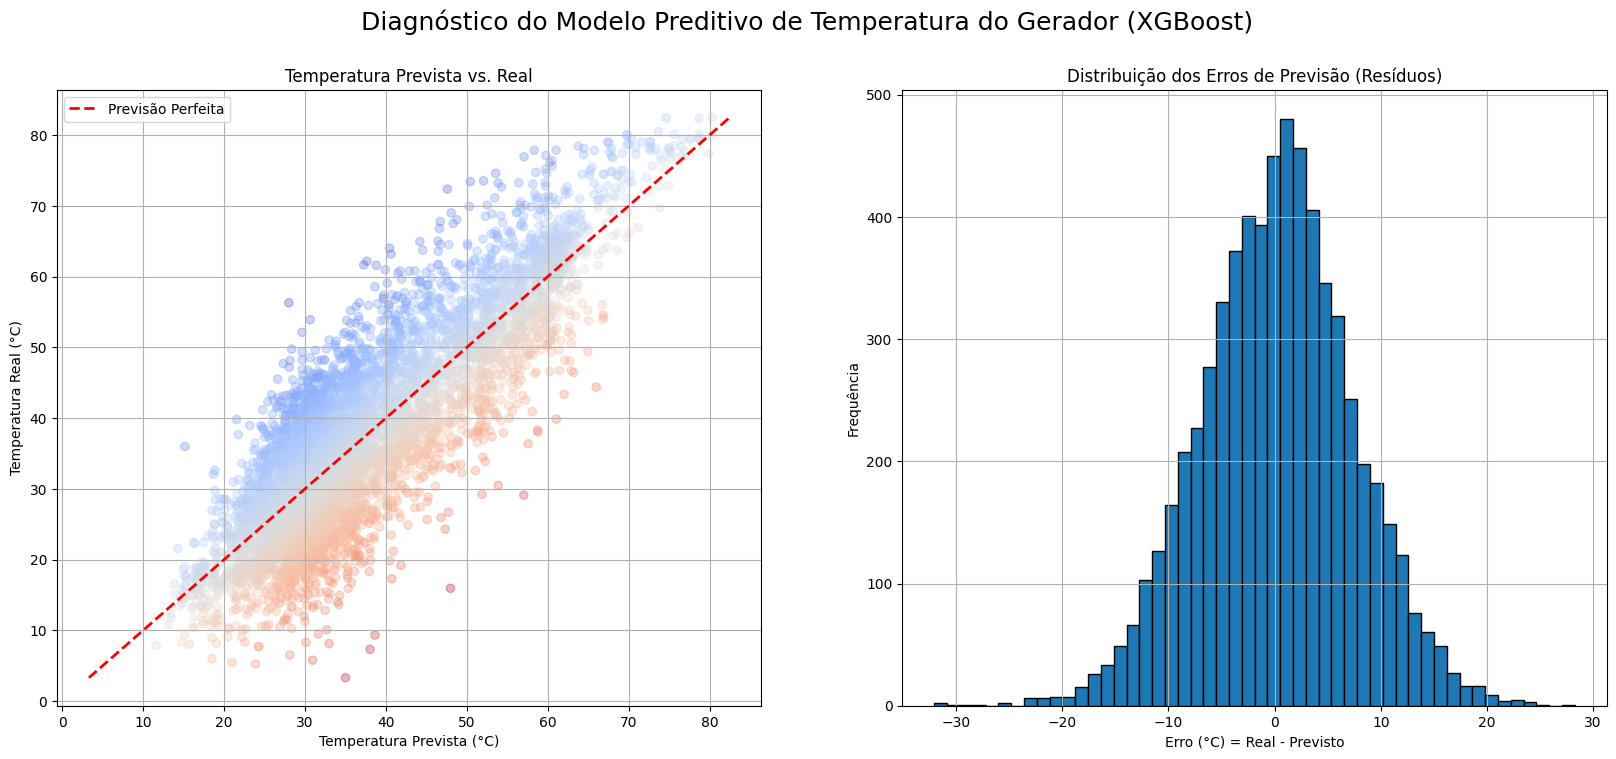

In [10]:
# --- PASSO 0: IMPORTAÇÃO DAS BIBLIOTECAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb # Importando a biblioteca XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

try:
    # --- PASSO 1: CARGA E PREPARAÇÃO INICIAL ---
    file_path = 'dataset/Aventa_AV7_IET_OST_SCADA.csv'
    df = pd.read_csv(file_path)
    print(f"Arquivo '{file_path}' carregado com sucesso!")
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # --- PASSO 2: REAMOSTRAGEM (INCLUINDO A TEMPERATURA) ---
    print("\n--- Reamostrando dados para médias de 10 minutos ---")
    # ATUALIZAÇÃO: Adicionamos 'GeneratorTemperature' à agregação
    agregacoes = {
        'WindSpeed': ['mean', 'count'],
        'RotorSpeed': ['mean'],
        'PowerOutput': ['mean'],
        'StatusAnlage': ['mean'],
        'GeneratorTemperature': ['mean'] # Variável alvo da nossa previsão
    }
    df_agg = df.resample('10T').agg(agregacoes)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    # --- PASSO 3: FILTRO DE QUALIDADE E LIMPEZA DE DADOS ---
    pontos_esperados = 600
    limiar_disponibilidade = 0.9
    df_final = df_agg[df_agg['WindSpeed_count'] >= (pontos_esperados * limiar_disponibilidade)].copy()

    codigos_validos = [10, 13] # Focando nos status de operação e falha
    df_limpo = df_final[df_final['StatusAnlage_mean'].round().isin(codigos_validos)].copy()
    
    # --- PASSO 4: ISOLAR DADOS DE OPERAÇÃO NORMAL PARA TREINAMENTO ---
    STATUS_OPERACAO = 10
    df_operacao = df_limpo[df_limpo['StatusAnlage_mean'].round() == STATUS_OPERACAO].copy()
    
    # Removemos linhas com dados nulos que podem ter surgido
    df_operacao.dropna(inplace=True)

    if df_operacao.empty:
        print("AVISO: Nenhum dado de operação normal (Status 10) foi encontrado.")
    else:
        print(f"Dados de operação normal prontos para modelagem: {len(df_operacao)} registros.")

        # --- PASSO 5: MODELAGEM PREDITIVA DE TEMPERATURA COM XGBOOST ---
        print("\n--- Iniciando a Modelagem Preditiva de Temperatura com XGBoost ---")

        # Definimos nossas múltiplas variáveis de entrada (X) e nosso alvo (y)
        features = ['PowerOutput_mean', 'RotorSpeed_mean', 'WindSpeed_mean']
        target = 'GeneratorTemperature_mean'
        
        X = df_operacao[features]
        y = df_operacao[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Instanciamos o modelo XGBoost Regressor
        xgb_model = xgb.XGBRegressor(
            n_estimators=500,      # Número de árvores
            learning_rate=0.05,    # Taxa de aprendizado (quão rápido o modelo aprende)
            max_depth=5,           # Profundidade máxima de cada árvore
            n_jobs=-1,             # Usar todos os processadores
            random_state=42
        )
        
        print("Treinando o modelo XGBoost...")
        xgb_model.fit(X_train, y_train)
        print("Modelo treinado com sucesso!")

        # --- PASSO 6: AVALIAÇÃO E ANÁLISE DE RESÍDUOS ---
        y_pred = xgb_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print("\n--- Performance do Modelo de Temperatura ---")
        print(f"Erro Médio Absoluto (MAE): {mae:.2f} °C")
        print(f"Coeficiente de Determinação (R²): {r2:.3f}")
        
        # Calculamos os resíduos (o erro para cada ponto)
        residuals = y_test - y_pred

        # --- PASSO 7: VISUALIZAÇÃO DE DIAGNÓSTICO ---
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Diagnóstico do Modelo Preditivo de Temperatura do Gerador (XGBoost)', fontsize=18)
        
        # Gráfico 1: Previsto vs. Real
        axs[0].scatter(y_pred, y_test, alpha=0.3, c=residuals, cmap='coolwarm_r')
        axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Previsão Perfeita')
        axs[0].set_title('Temperatura Prevista vs. Real')
        axs[0].set_xlabel('Temperatura Prevista (°C)')
        axs[0].set_ylabel('Temperatura Real (°C)')
        axs[0].legend()
        axs[0].grid(True)
        
        # Gráfico 2: Distribuição dos Resíduos (Erros)
        axs[1].hist(residuals, bins=50, edgecolor='k')
        axs[1].set_title('Distribuição dos Erros de Previsão (Resíduos)')
        axs[1].set_xlabel('Erro (°C) = Real - Previsto')
        axs[1].set_ylabel('Frequência')
        axs[1].grid(True)
        
        plt.show()

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho '{file_path}'")